# 1. Framing the Business Problem
Customer churn refers to when customers stop using a company's products or services. For telecom companies, predicting which customers are likely to churn is crucial for several reasons:

Revenue Retention: It costs 5-25x more to acquire new customers than to retain existing ones
Targeted Interventions: Identifying at-risk customers allows for proactive retention efforts
Understanding Pain Points: Churn analysis reveals product/service weaknesses

Machine Learning Problem Statement:
We will build a classification model that predicts whether a customer will churn in the near future based on their profile and usage patterns. This is a binary classification problem (churn: yes/no).

# 2. Defining Relevant Metrics
When dealing with churn prediction, we need to consider appropriate evaluation metrics:

Recall/Sensitivity: The percentage of actual churners correctly identified (higher priority as missing a potential churner is costly)
Precision: The percentage of predicted churners who actually churn
F1-Score: Harmonic mean of precision and recall
AUC-ROC: Area Under the Receiver Operating Characteristic curve (measures model's ability to distinguish between classes)
Business Impact Metrics: Cost savings from retention campaigns, ROI of predictive model

For business teams, we should set expectations about:

Trade-offs between different metrics (e.g., higher recall often means lower precision)
Realistic performance benchmarks based on industry standards
Implementation timeline and resource requirements

# 3. Data Understanding and Exploratory Data Analysis

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid')

# Load data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# First look at the data
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3.1 Data Overview

In [8]:
# Check column information
df.info()

# Summary statistics
df.describe().T

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check target variable distribution
print("\nTarget variable distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3.2 Univariate Analysis
Let's analyze the distribution of key variables:

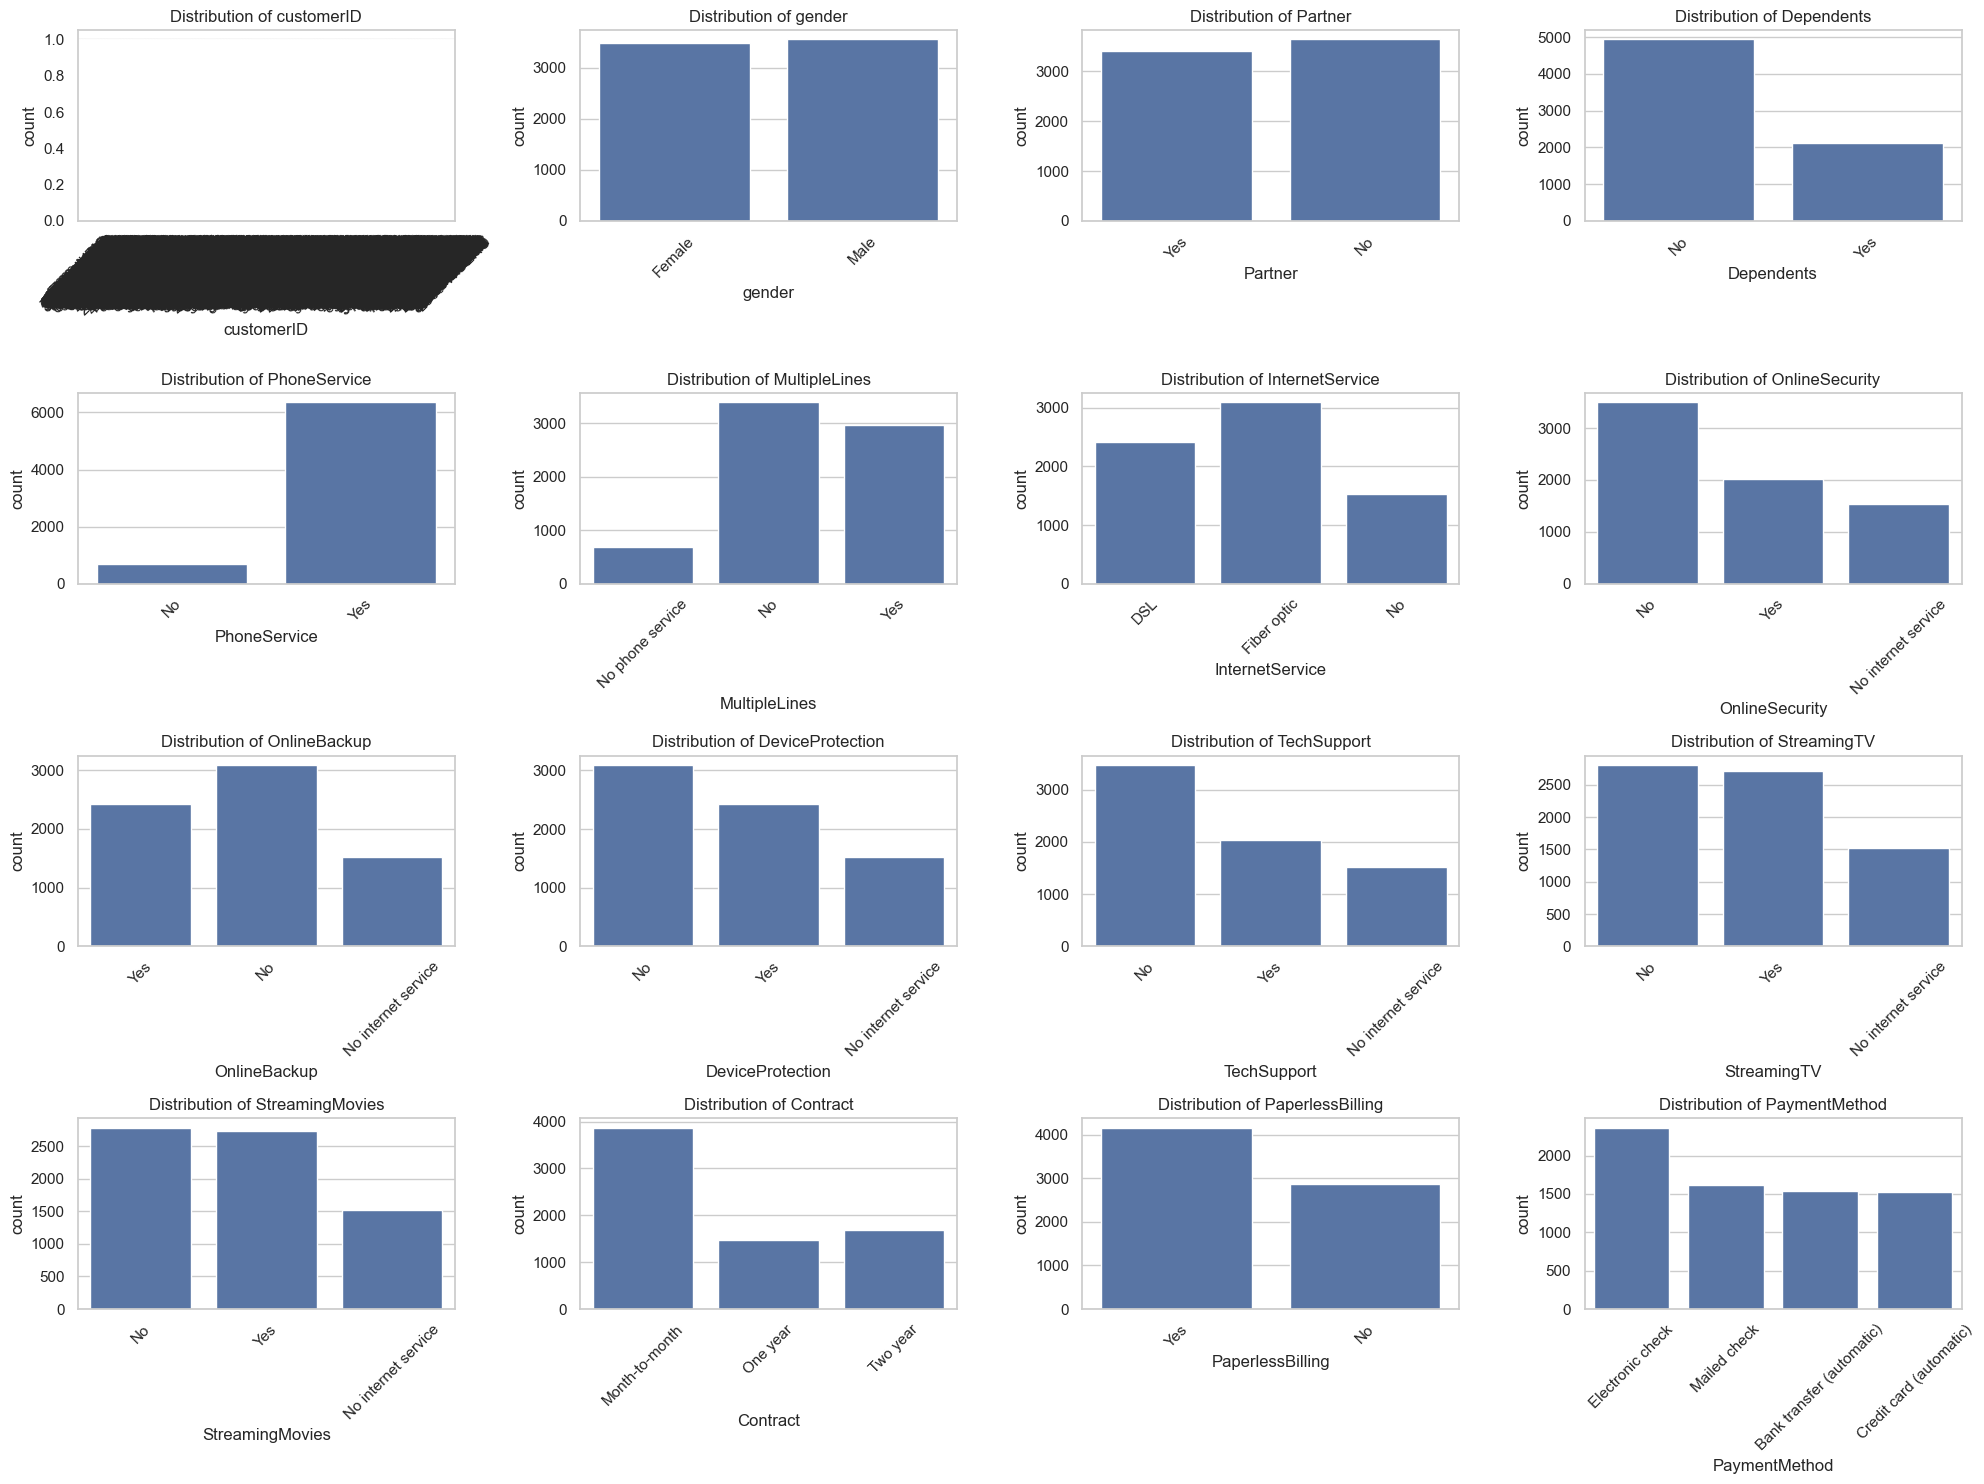

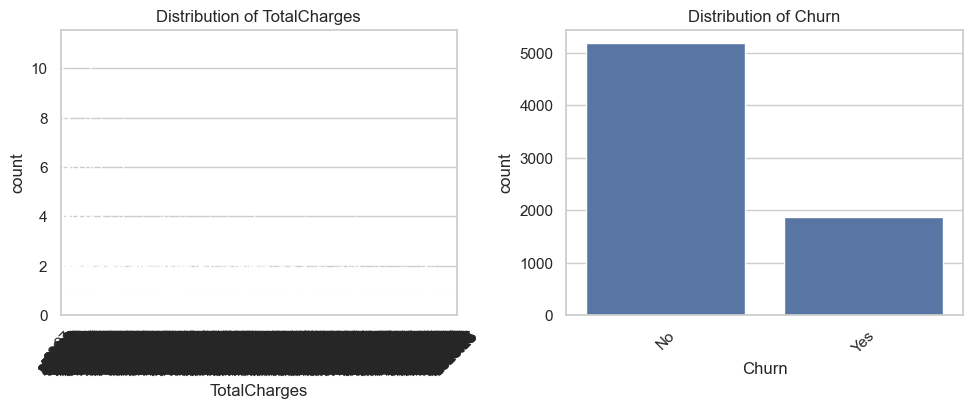

In [9]:
# Split into multiple figures with 16 plots max per figure
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
max_plots_per_figure = 16  # 4x4 grid
num_figures = (len(categorical_cols) + max_plots_per_figure - 1) // max_plots_per_figure

for fig_num in range(num_figures):
    plt.figure(figsize=(20, 15))
    
    start_idx = fig_num * max_plots_per_figure
    end_idx = min((fig_num + 1) * max_plots_per_figure, len(categorical_cols))
    
    for i, col_idx in enumerate(range(start_idx, end_idx), 1):
        col = categorical_cols[col_idx]
        plt.subplot(4, 4, i)
        sns.countplot(x=col, data=df)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

3.3 Bivariate Analysis
Let's analyze the relationship between features and the target variable:

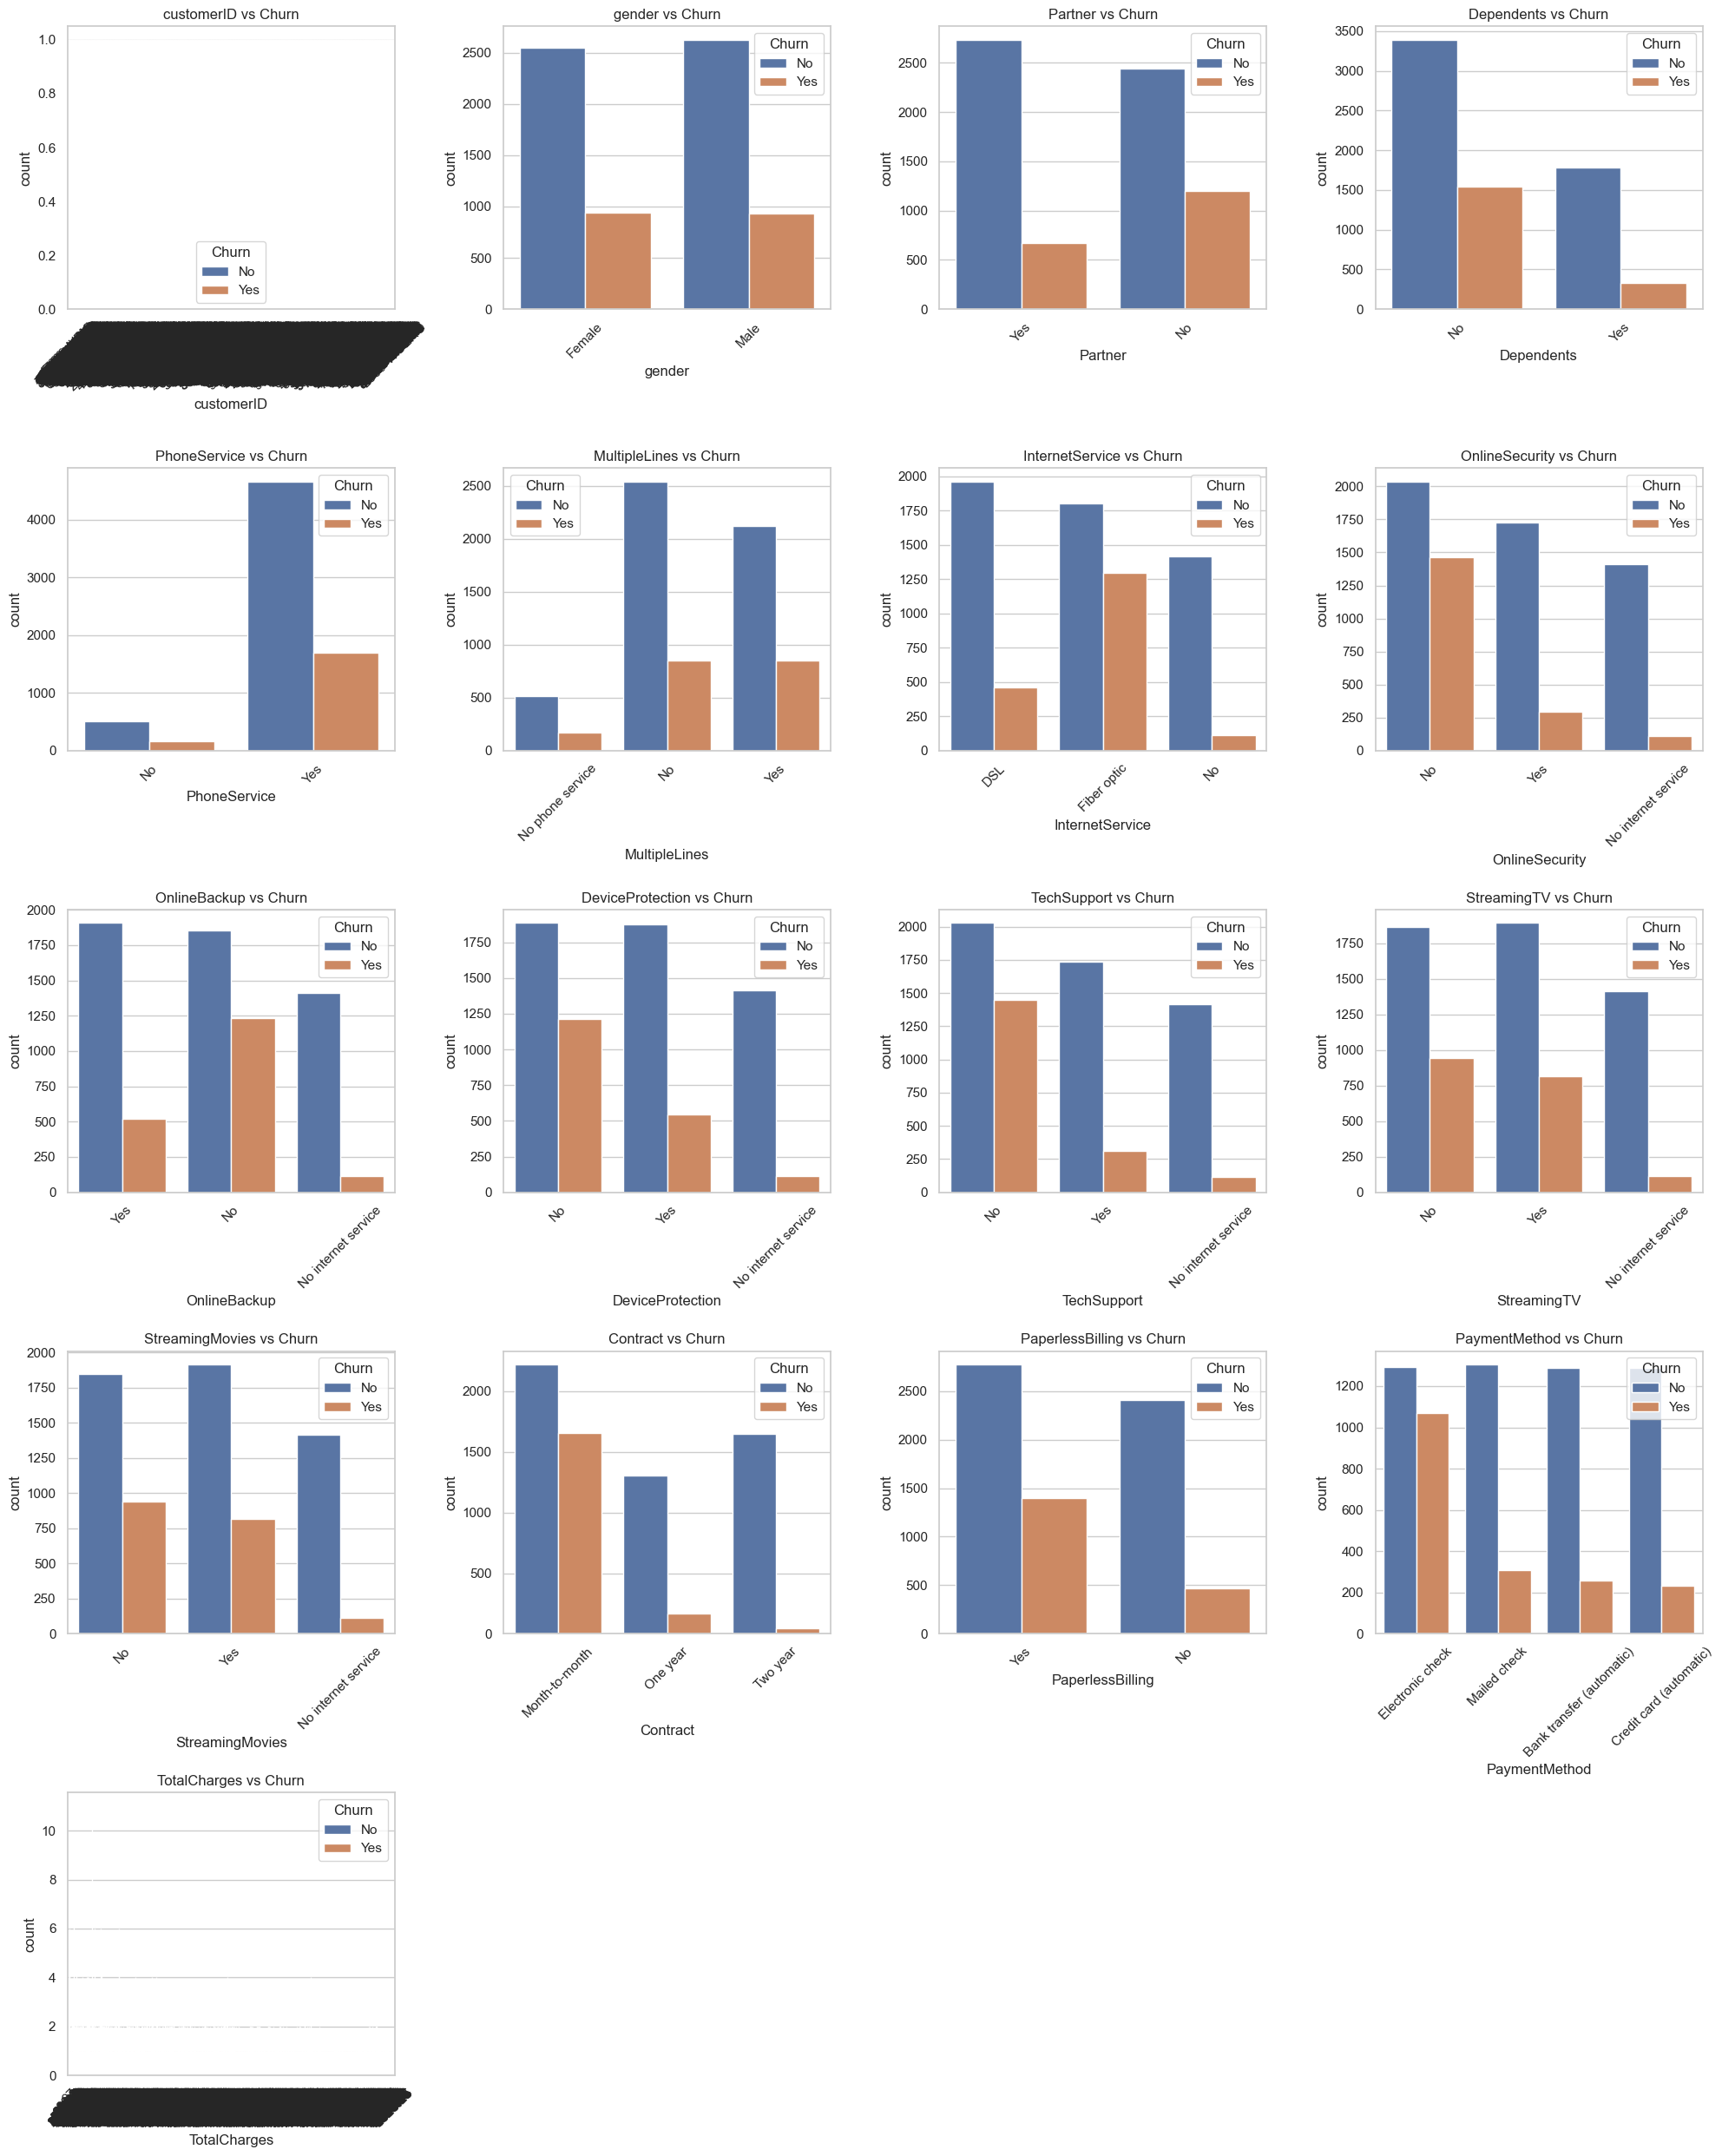

In [10]:
# Create a copy of the DataFrame for visualization purposes
viz_df = df.copy()

# For categorical features vs Churn
# First, get categorical columns excluding Churn
cat_cols_no_churn = [col for col in categorical_cols if col != 'Churn']
num_cols = len(cat_cols_no_churn)
rows = (num_cols + 3) // 4  # Calculate needed rows (ceiling division)

plt.figure(figsize=(20, 5*rows))
for i, col in enumerate(cat_cols_no_churn, 1):
    plt.subplot(rows, 4, i)
    sns.countplot(x=col, hue='Churn', data=viz_df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



4. Data Preprocessing
4.1 Missing Value Treatment

In [11]:
# Convert TotalCharges to numeric (it might be stored as object due to spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values again
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values in TotalCharges
# Option 1: Impute with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Option 2: For customers with 0 tenure, we could set TotalCharges to 0
# df.loc[df['tenure'] == 0, 'TotalCharges'] = 0

Missing values per column:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


4.2 Outlier Treatment

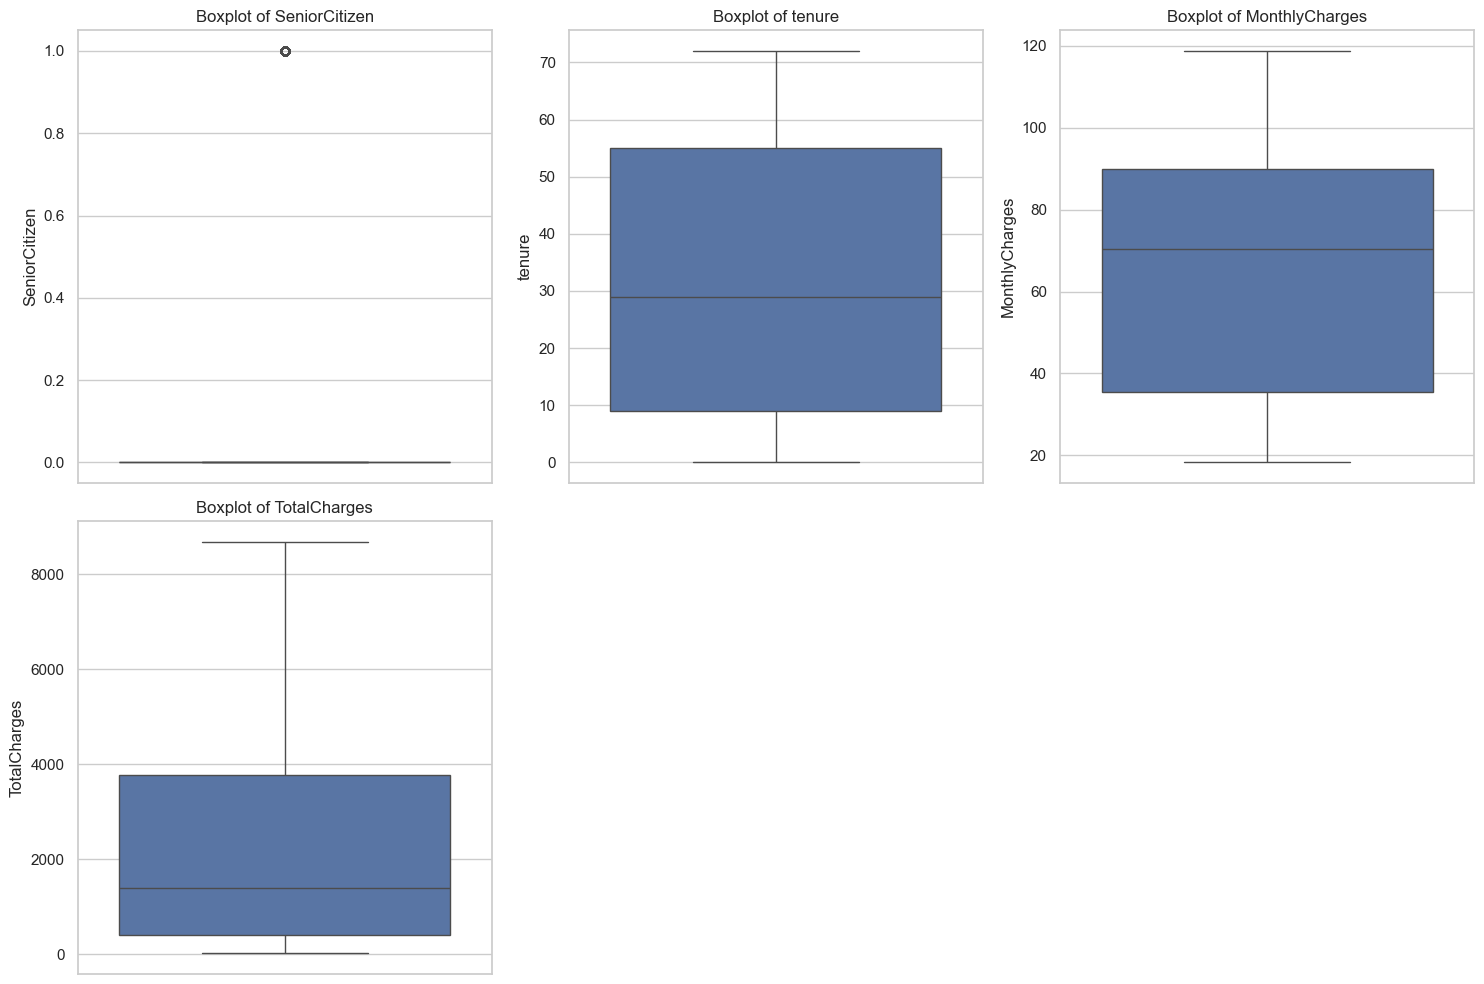

In [13]:
# Function to detect and visualize outliers using boxplots
def detect_outliers(df, numeric_cols):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

# First define numerical_cols by selecting numerical data types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Then filter out customerID
numeric_cols = [col for col in numerical_cols if col not in ['customerID']]
detect_outliers(df, numeric_cols)

# We can use IQR method to cap outliers if necessary
# Example for one column:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col] = np.where(df[col] > upper_bound, upper_bound,
                       np.where(df[col] < lower_bound, lower_bound, df[col]))
    return df

# Apply to numeric columns if needed
# for col in numeric_cols:
#     df = cap_outliers(df, col)

5. Feature Engineering and Encoding
5.1 Feature Engineering

In [14]:
# Create new features that might be useful for prediction
# 1. Average monthly charges
df['AvgMonthlyCharges'] = df['TotalCharges'] / (df['tenure'] + 1)  # Adding 1 to avoid division by zero

# 2. Total services subscribed
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalServices'] = 0
for service in services:
    # For binary yes/no columns
    if set(df[service].unique()) == {'Yes', 'No'} or set(df[service].unique()) == {'Yes', 'No', 'No internet service'}:
        df['TotalServices'] += np.where(df[service] == 'Yes', 1, 0)
    # For internet service which has 'DSL', 'Fiber optic', 'No'
    elif service == 'InternetService':
        df['TotalServices'] += np.where(df[service] != 'No', 1, 0)

# 3. Contract category (group by contract length)
df['ContractCategory'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# 4. Senior citizen family indicator
df['SeniorFamily'] = np.where((df['SeniorCitizen'] == 1) & (df['Partner'] == 'Yes'), 1, 0)

# 5. Value customer indicator (high monthly charges, long tenure)
df['ValueCustomer'] = np.where((df['tenure'] > df['tenure'].median()) & 
                              (df['MonthlyCharges'] > df['MonthlyCharges'].median()), 1, 0)

5.2 Label Encoding / One-Hot Encoding

In [15]:
# Drop customerID as it's not useful for modeling
df.drop('customerID', axis=1, inplace=True)

# Identify categorical columns (excluding target variable)
categorical_features = [col for col in df.select_dtypes(include=['object']).columns if col != 'Churn']

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Handle the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_encoded['Churn'] = le.fit_transform(df['Churn'])

# Map the encoded values to original labels for reference
churn_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Churn Mapping:", churn_mapping)

Churn Mapping: {'No': 0, 'Yes': 1}


5.3 Handling New Categorical Levels
For production systems, you need to handle potential new categories that weren't present in training:

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Create a more robust encoding process using sklearn's OneHotEncoder
def encode_categorical_features(train_df, test_df, categorical_cols):
    # Initialize the encoder
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # Fit on training data
    encoder.fit(train_df[categorical_cols])
    
    # Transform both training and test data
    train_encoded = encoder.transform(train_df[categorical_cols])
    test_encoded = encoder.transform(test_df[categorical_cols])
    
    # Get feature names
    feature_names = [f"{col}_{cat}" for i, col in enumerate(categorical_cols) 
                     for cat in encoder.categories_[i]]
    
    # Convert to DataFrame
    train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=train_df.index)
    test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=test_df.index)
    
    # Drop original categorical columns and concat encoded features
    train_df = train_df.drop(categorical_cols, axis=1)
    test_df = test_df.drop(categorical_cols, axis=1)
    
    train_df = pd.concat([train_df, train_encoded_df], axis=1)
    test_df = pd.concat([test_df, test_encoded_df], axis=1)
    
    return train_df, test_df, encoder

# This function would be used with train/test splits
# Example usage:
# train_encoded, test_encoded, encoder = encode_categorical_features(train, test, categorical_features)

6. Target Encoding and Avoiding Data Leakage
Target encoding is a technique where you replace a categorical value with the mean of the target variable for that value. It's effective but can lead to data leakage if not implemented correctly.

In [17]:
from sklearn.model_selection import KFold

def target_encode_kfold(df, column, target, n_folds=5):
    """
    Apply target encoding using k-fold to prevent data leakage
    """
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Create a new column for the encoded feature
    encoded_column = f"{column}_target_encoded"
    df_copy[encoded_column] = np.nan
    
    # Set up KFold
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # For each fold
    for train_idx, test_idx in kfold.split(df_copy):
        # Get the means from the training fold
        means = df_copy.iloc[train_idx].groupby(column)[target].mean()
        
        # Map the means to the test fold
        df_copy.loc[test_idx, encoded_column] = df_copy.iloc[test_idx][column].map(means)
    
    # Handle missing values (categories that didn't appear in a particular fold)
    global_mean = df_copy[target].mean()
    df_copy[encoded_column].fillna(global_mean, inplace=True)
    
    return df_copy, encoded_column

# Example application for a categorical column
# df_encoded, new_col = target_encode_kfold(df, 'Contract', 'Churn')

7. Feature Transforms and Feature Selection
7.1 Feature Scaling

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Identify numerical columns for scaling
numeric_features = [col for col in df_encoded.select_dtypes(include=['int64', 'float64']).columns 
                    if col != 'Churn']  # Exclude target

# StandardScaler (Z-score normalization)
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

# Alternative: MinMaxScaler (scales to range [0,1])
# minmax_scaler = MinMaxScaler()
# df_encoded[numeric_features] = minmax_scaler.fit_transform(df_encoded[numeric_features])

7.2 Feature Selection using RFE

In [19]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the model
base_model = RandomForestClassifier(random_state=42)

# Initialize RFE with the desired number of features
n_features_to_select = 15  # Example: select top 15 features
rfe = RFE(estimator=base_model, n_features_to_select=n_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected features
selected_features = [feature for feature, selected in zip(X.columns, rfe.support_) if selected]
print(f"Selected features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Create a dataframe with only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Selected features (15):
1. SeniorCitizen
2. tenure
3. MonthlyCharges
4. TotalCharges
5. AvgMonthlyCharges
6. TotalServices
7. ContractCategory
8. gender_Male
9. Partner_Yes
10. Dependents_Yes
11. InternetService_Fiber optic
12. OnlineSecurity_Yes
13. OnlineBackup_Yes
14. PaperlessBilling_Yes
15. PaymentMethod_Electronic check


8. Solving Class Imbalance
Churn data is often imbalanced. Here are techniques to address this:
8.1 Resampling Techniques

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Check class distribution
print("Original class distribution:")
print(y_train.value_counts(normalize=True) * 100)

# 1. Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)
print("\nSMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts(normalize=True) * 100)

# 2. Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_selected, y_train)
print("\nUndersampling class distribution:")
print(pd.Series(y_train_rus).value_counts(normalize=True) * 100)

# 3. Combined approach: SMOTE + ENN
smote_enn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_selected, y_train)
print("\nSMOTEENN class distribution:")
print(pd.Series(y_train_smoteenn).value_counts(normalize=True) * 100)

Original class distribution:
Churn
0    73.464679
1    26.535321
Name: proportion, dtype: float64

SMOTE class distribution:
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64

Undersampling class distribution:
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64

SMOTEENN class distribution:
Churn
1    53.218302
0    46.781698
Name: proportion, dtype: float64


8.2 Class Weights

In [21]:
# Instead of resampling, we can use class_weight parameter in many sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Use 'balanced' for automatic weight calculation based on class frequencies
rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_balanced.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_balanced = rf_balanced.predict(X_test_selected)
print("Classification report with balanced class weights:")
print(classification_report(y_test, y_pred_balanced))

Classification report with balanced class weights:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.63      0.46      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



9. Model Training and Evaluation
Let's implement and evaluate several models:

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
import time

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Start time
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # End time
    train_time = time.time() - start_time
    
    # Make predictions (both class labels and probabilities)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Compile results
    results = {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'train_time': train_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Evaluate all models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_smote, X_test_selected, y_train_smote, y_test, name)
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1-Score: {results[name]['f1_score']:.4f}")
    print(f"ROC-AUC: {results[name]['roc_auc']:.4f}")
    print(f"Training Time: {results[name]['train_time']:.2f} seconds")
    print("\nConfusion Matrix:")
    print(results[name]['confusion_matrix'])
    print("\nClassification Report:")
    print(classification_report(y_test, results[name]['y_pred']))


Logistic Regression Results:
Accuracy: 0.7310
Precision: 0.4958
Recall: 0.7834
F1-Score: 0.6073
ROC-AUC: 0.8366
Training Time: 0.06 seconds

Confusion Matrix:
[[737 298]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.79      0.73      0.75      1409


Random Forest Results:
Accuracy: 0.7700
Precision: 0.5587
Recall: 0.6364
F1-Score: 0.5950
ROC-AUC: 0.8157
Training Time: 0.66 seconds

Confusion Matrix:
[[847 188]
 [136 238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72    

9.1 Visualization of Model Performance

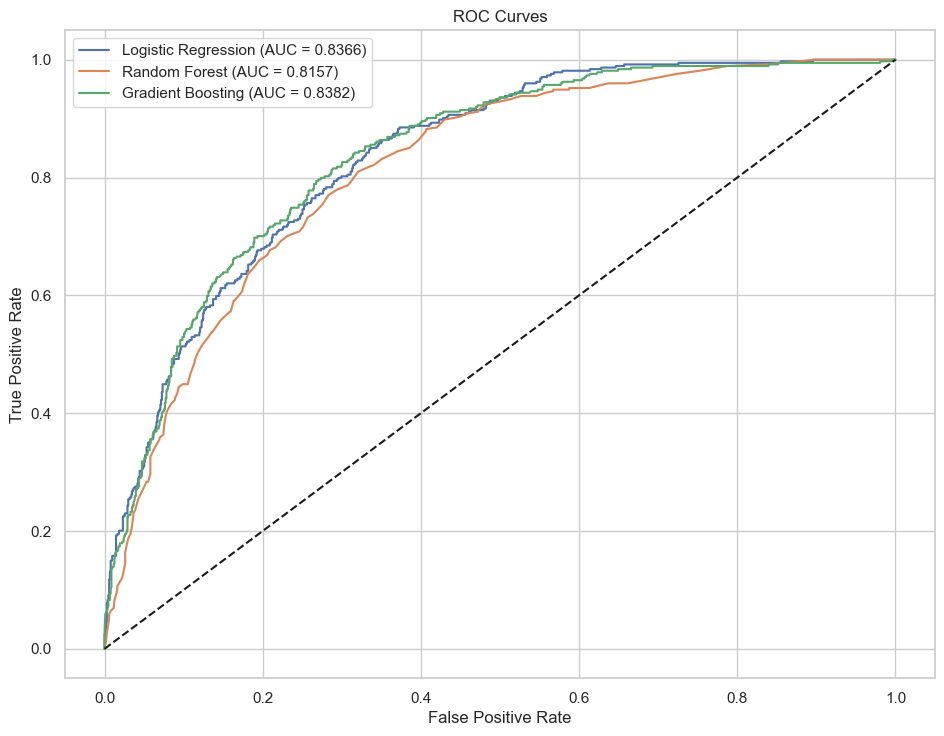

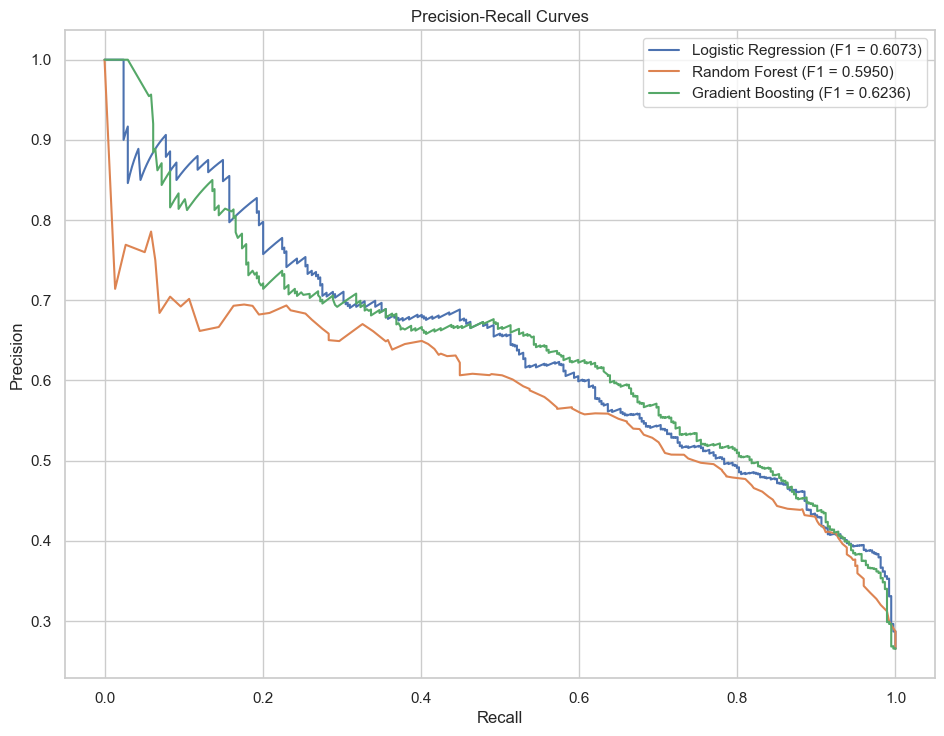

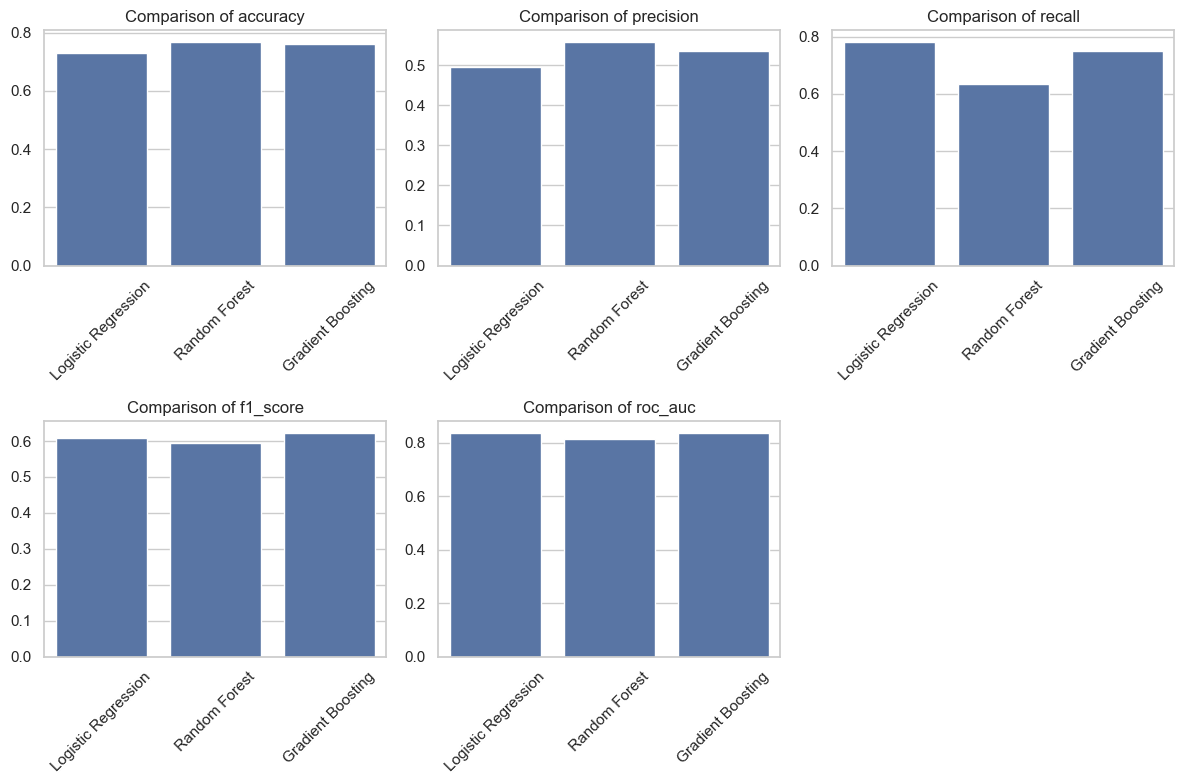

In [23]:
# Visualize ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Visualize Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    plt.plot(recall, precision, label=f"{name} (F1 = {result['f1_score']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

# Compare metrics across models
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
model_names = list(results.keys())

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    # Use the actual metric name instead of 'metric_value'
    values = [results[model][metric] for model in model_names]
    sns.barplot(x=model_names, y=values)
    plt.title(f'Comparison of {metric}')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

# 10. Model Explainability and Interpretability
## 10.1 Feature Importance

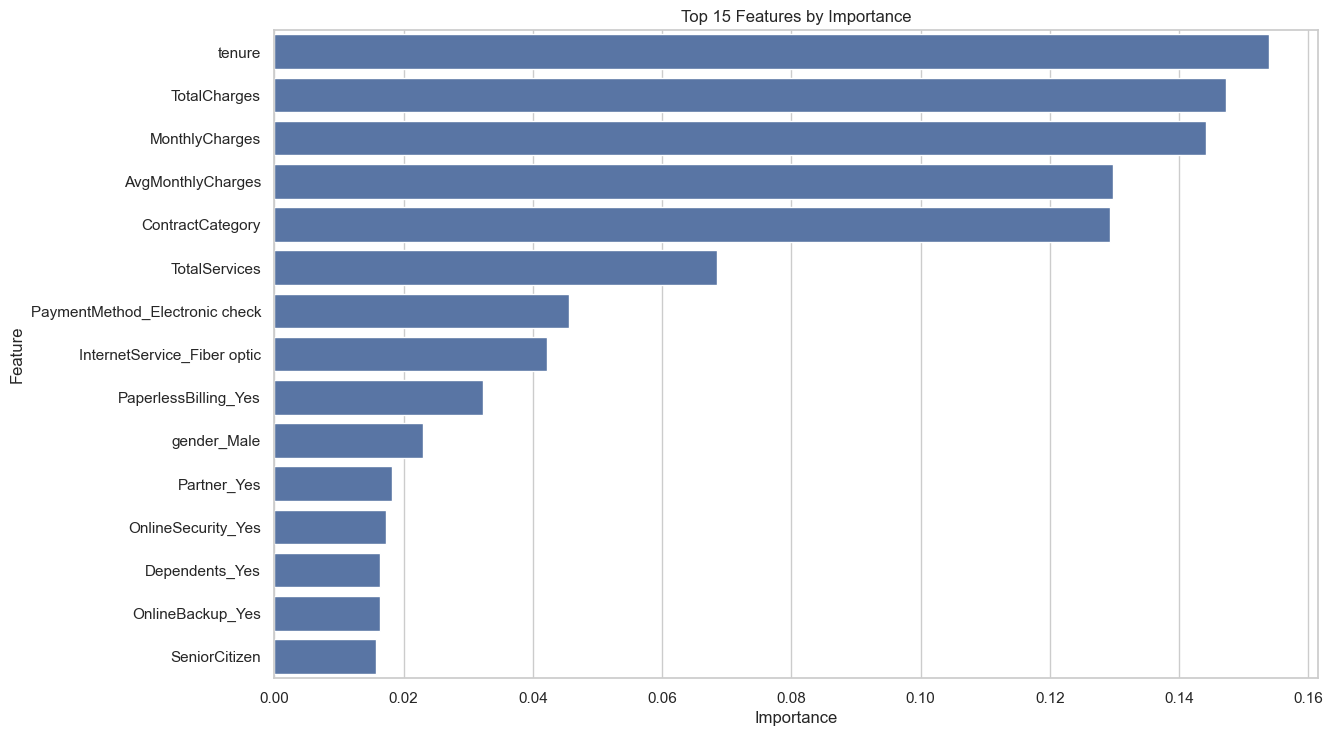

In [24]:
# Get feature importance from Random Forest model
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.show()

## 10.2 Decision Tree Visualization

Number of features in X_train_selected: 15
Number of features used by the tree: 15


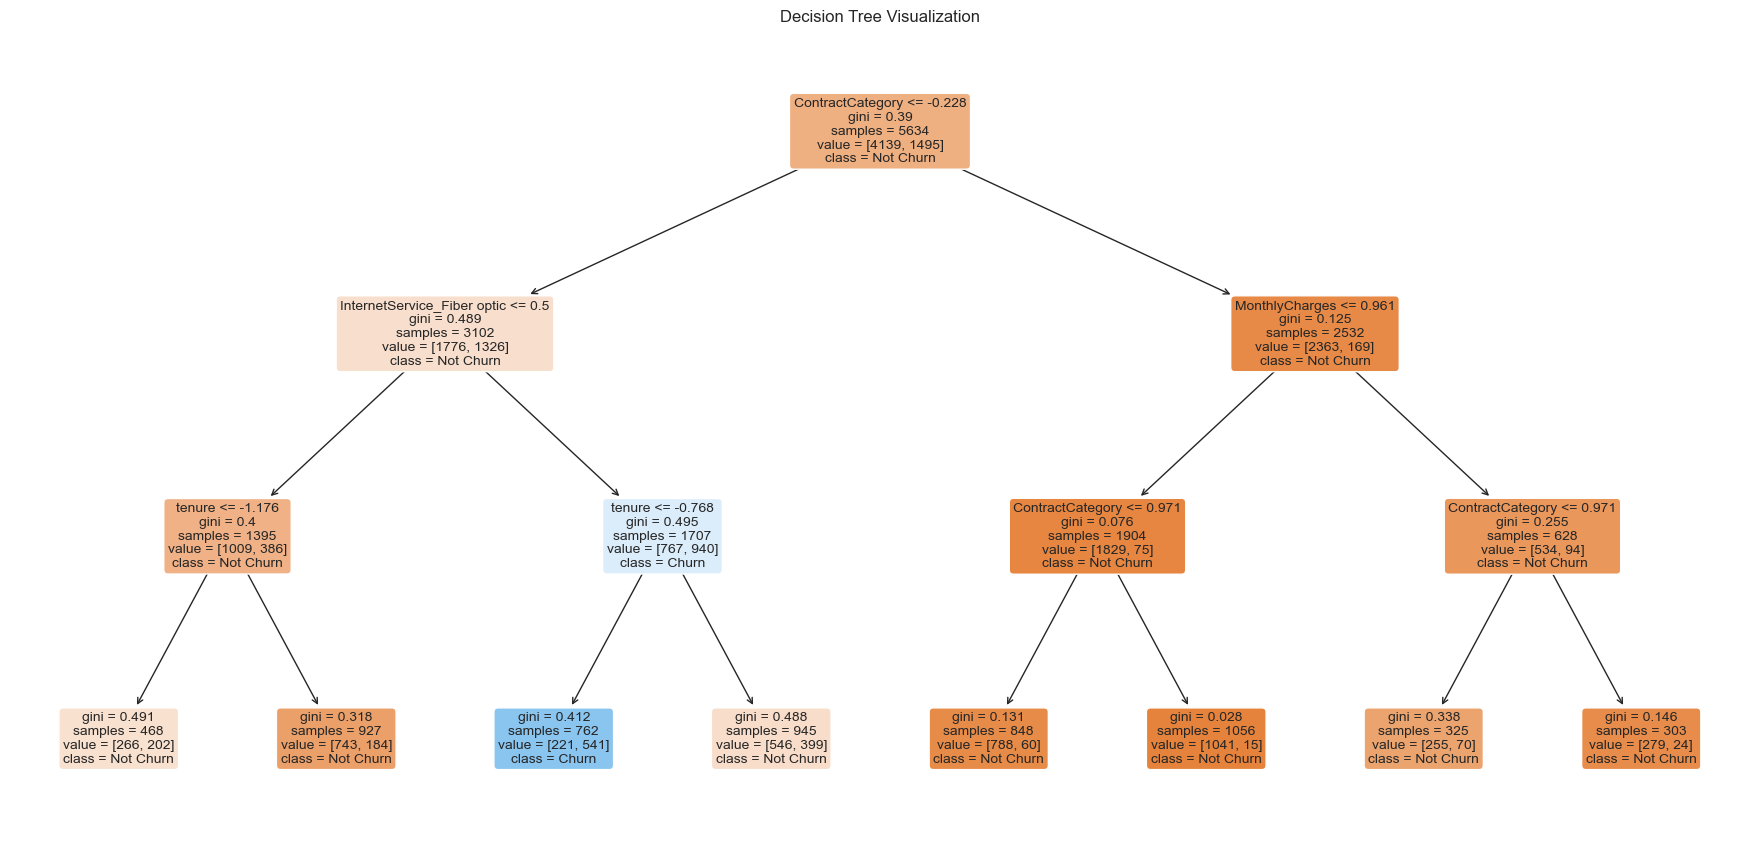

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a simple decision tree for visualization
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_selected, y_train)

# Check feature counts to debug the issue
print(f"Number of features in X_train_selected: {X_train_selected.shape[1]}")
print(f"Number of features used by the tree: {dt.n_features_in_}")

# Option 1: Convert column names to list (sometimes fixes index issues)
feature_names = list(X_train_selected.columns)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=feature_names, 
          class_names=['Not Churn', 'Churn'], rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

## 10.3 SHAP Values

<Figure size 1200x1000 with 0 Axes>

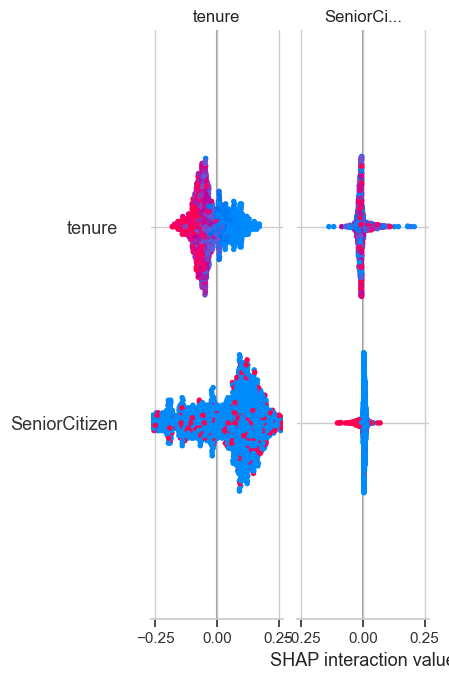

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

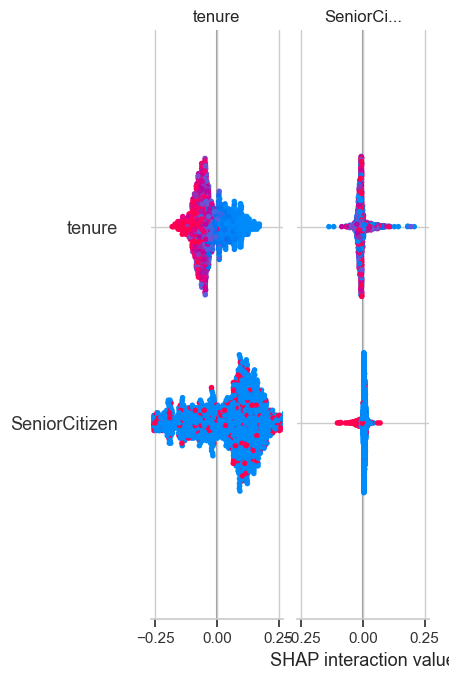

<Figure size 640x480 with 0 Axes>

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

<Figure size 1200x800 with 0 Axes>

In [31]:
import shap

# Initialize JS visualization
shap.initjs()

# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_selected)

# Summary plot - bar chart for feature importance
plt.figure(figsize=(12, 10))
if isinstance(shap_values, list):
    # For binary classification (shap_values will be a list of arrays)
    shap.summary_plot(shap_values[1], X_test_selected, plot_type="bar")
else:
    # For regression or other types
    shap.summary_plot(shap_values, X_test_selected, plot_type="bar")
plt.tight_layout()
plt.show()

# Beeswarm plot - showing feature distribution and impact
plt.figure(figsize=(12, 10))
if isinstance(shap_values, list):
    # For binary classification
    shap.summary_plot(shap_values[1], X_test_selected)
else:
    # For regression
    shap.summary_plot(shap_values, X_test_selected)
plt.tight_layout()
plt.show()

# For individual explanations - use waterfall plot instead of force plot
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    # For binary classification - explain the prediction for the first sample
    shap.plots.waterfall(shap_values[1][0], max_display=10)
else:
    # For regression
    shap.plots.waterfall(shap_values[0], max_display=10)
plt.tight_layout()
plt.show()

# For comparing multiple samples - use a decision plot 
plt.figure(figsize=(12, 10))
if isinstance(shap_values, list):
    # For first 10 samples in binary classification
    shap.decision_plot(explainer.expected_value[1], shap_values[1][:10], 
                       X_test_selected.iloc[:10], feature_display_range=10)
else:
    # For regression
    shap.decision_plot(explainer.expected_value, shap_values[:10], 
                       X_test_selected.iloc[:10], feature_display_range=10)
plt.tight_layout()
plt.show()

# 11. Hyperparameter Tuning
## 11.1 RandomSearchCV

In [32]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,     # Use all available processors
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_smote, y_train_smote)

# Get best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

# Train model with best parameters
best_rf = random_search.best_estimator_
best_rf_results = evaluate_model(best_rf, X_train_smote, X_test_selected, y_train_smote, y_test, 'Tuned Random Forest')

# Print results
print("\nTuned Random Forest Results:")
print(f"Accuracy: {best_rf_results['accuracy']:.4f}")
print(f"Precision: {best_rf_results['precision']:.4f}")
print(f"Recall: {best_rf_results['recall']:.4f}")
print(f"F1-Score: {best_rf_results['f1_score']:.4f}")
print(f"ROC-AUC: {best_rf_results['roc_auc']:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': None, 'bootstrap': False}
Best F1 Score: 0.8454153666175811

Tuned Random Forest Results:
Accuracy: 0.7658
Precision: 0.5526
Recall: 0.6176
F1-Score: 0.5833
ROC-AUC: 0.8129


## 11.2 GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV

# Based on RandomSearchCV results, we can narrow down the parameter space for GridSearchCV
param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=5,            # 5-fold cross-validation
    scoring='f1',    # Optimize for F1-score
    n_jobs=-1,       # Use all available processors
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Get best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Train model with best parameters
best_gb = grid_search.best_estimator_
best_gb_results = evaluate_model(best_gb, X_train_smote, X_test_selected, y_train_smote, y_test, 'Tuned Gradient Boosting')

# Print results
print("\nTuned Gradient Boosting Results:")
print(f"Accuracy: {best_gb_results['accuracy']:.4f}")
print(f"Precision: {best_gb_results['precision']:.4f}")
print(f"Recall: {best_gb_results['recall']:.4f}")
print(f"F1-Score: {best_gb_results['f1_score']:.4f}")
print(f"ROC-AUC: {best_gb_results['roc_auc']:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Best F1 Score: 0.8219691700510412

Tuned Gradient Boosting Results:
Accuracy: 0.7637
Precision: 0.5428
Recall: 0.6952
F1-Score: 0.6096
ROC-AUC: 0.8351


# 12. Ensembling Multiple Models
Let's create ensemble models using VotingClassifier and StackingClassifier:

In [34]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# 12.1 Voting Classifier
# Combine best models using soft voting (weighted probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', results['Logistic Regression']['model']),
        ('rf', best_rf),
        ('gb', best_gb)
    ],
    voting='soft'  # Use predicted probabilities
)

# Train and evaluate
voting_results = evaluate_model(voting_clf, X_train_smote, X_test_selected, y_train_smote, y_test, 'Voting Classifier')

# Print results
print("\nVoting Classifier Results:")
print(f"Accuracy: {voting_results['accuracy']:.4f}")
print(f"Precision: {voting_results['precision']:.4f}")
print(f"Recall: {voting_results['recall']:.4f}")
print(f"F1-Score: {voting_results['f1_score']:.4f}")
print(f"ROC-AUC: {voting_results['roc_auc']:.4f}")

# 12.2 Stacking Classifier
# Use a meta-learner on top of base models
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', results['Logistic Regression']['model']),
        ('rf', best_rf),
        ('gb', best_gb)
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5  # 5-fold cross-validation
)

# Train and evaluate
stacking_results = evaluate_model(stacking_clf, X_train_smote, X_test_selected, y_train_smote, y_test, 'Stacking Classifier')

# Print results
print("\nStacking Classifier Results:")
print(f"Accuracy: {stacking_results['accuracy']:.4f}")
print(f"Precision: {stacking_results['precision']:.4f}")
print(f"Recall: {stacking_results['recall']:.4f}")
print(f"F1-Score: {stacking_results['f1_score']:.4f}")
print(f"ROC-AUC: {stacking_results['roc_auc']:.4f}")


Voting Classifier Results:
Accuracy: 0.7630
Precision: 0.5410
Recall: 0.7059
F1-Score: 0.6125
ROC-AUC: 0.8371

Stacking Classifier Results:
Accuracy: 0.7729
Precision: 0.5685
Recall: 0.5989
F1-Score: 0.5833
ROC-AUC: 0.8152


# 13. Error Analysis
Understanding the mistakes our model makes is crucial for improvement:

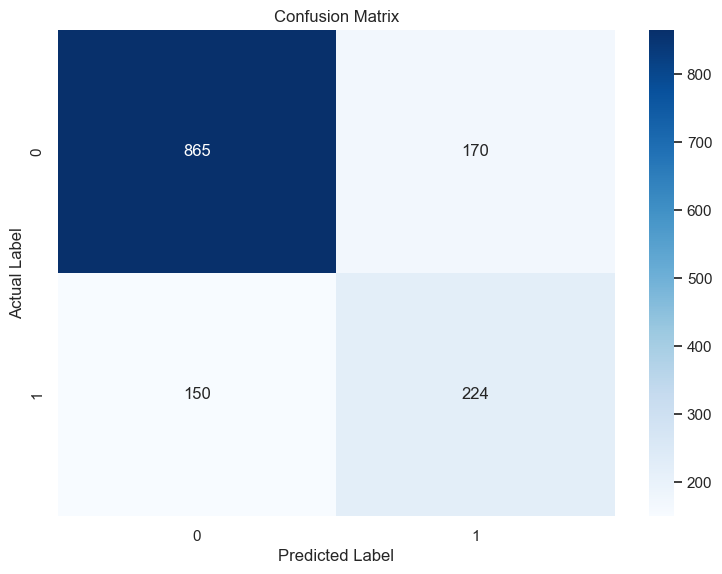

Number of false positives: 170
Number of false negatives: 150


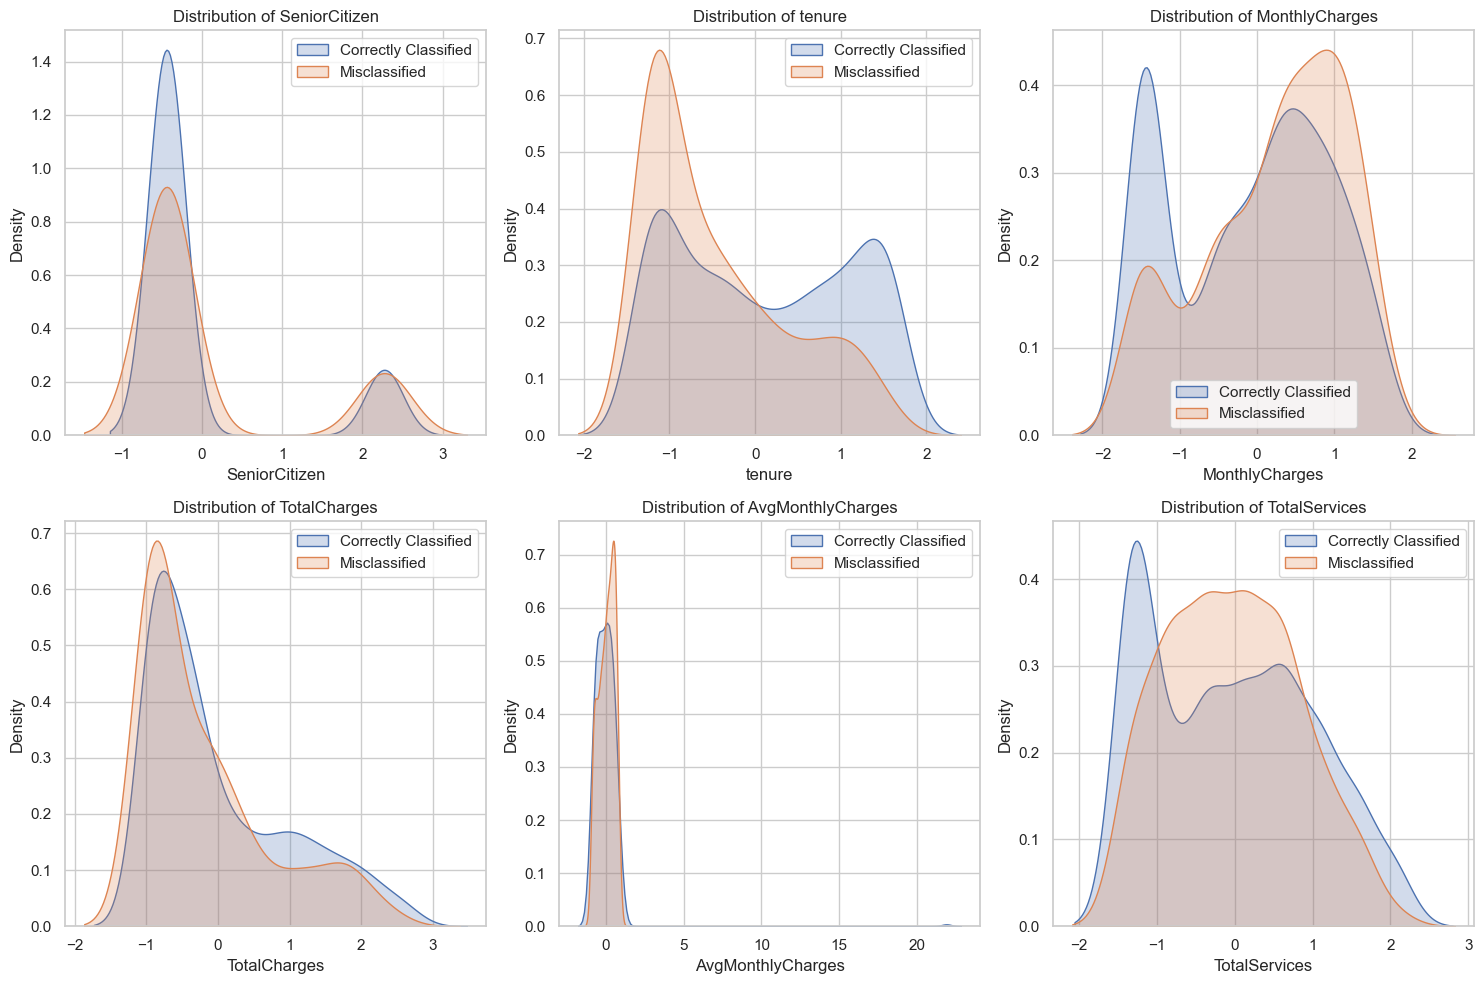

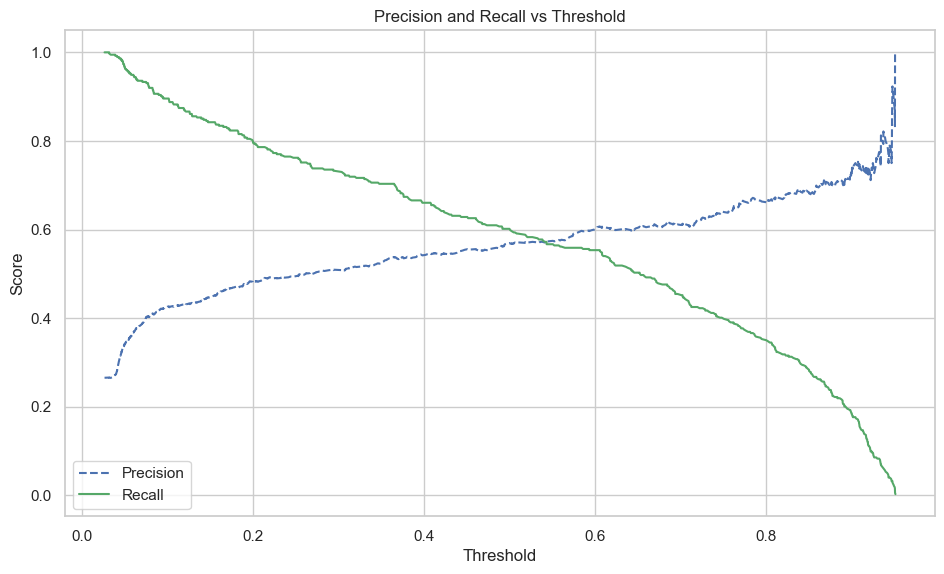

Optimal threshold for F1-score: 0.3648
Optimal F1-score: 0.6095
Classification report with optimal threshold:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get best model (based on prior evaluations)
best_model = stacking_clf  # Let's assume the stacking classifier is best
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# 13.1 Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 13.2 Identify misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_data = X_test.iloc[misclassified_indices].copy()
misclassified_data['actual_churn'] = y_test.iloc[misclassified_indices]
misclassified_data['predicted_churn'] = y_pred[misclassified_indices]
misclassified_data['churn_probability'] = y_pred_proba[misclassified_indices]

# Look at false positives (predicted churn when they didn't)
false_positives = misclassified_data[misclassified_data['predicted_churn'] == 1]
print(f"Number of false positives: {len(false_positives)}")

# Look at false negatives (didn't predict churn when they did)
false_negatives = misclassified_data[misclassified_data['predicted_churn'] == 0]
print(f"Number of false negatives: {len(false_negatives)}")

# 13.3 Analyze feature distributions in misclassified examples
# Compare misclassified examples with correctly classified ones
correctly_classified_indices = np.where(y_pred == y_test)[0]
correctly_classified_data = X_test.iloc[correctly_classified_indices].copy()

# For numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_test_selected.select_dtypes('number').columns[:6], 1):  # First 6 numerical features
    plt.subplot(2, 3, i)
    
    # Correctly classified
    sns.kdeplot(correctly_classified_data[col], label='Correctly Classified', shade=True)
    
    # Misclassified
    sns.kdeplot(misclassified_data[col], label='Misclassified', shade=True)
    
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.show()

# 13.4 Analyze probability thresholds
from sklearn.metrics import precision_recall_curve, roc_curve

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision and recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal threshold for F1-score
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Optimal threshold for F1-score: {optimal_threshold:.4f}")
print(f"Optimal F1-score: {f1_scores[optimal_threshold_idx]:.4f}")

# Apply optimal threshold and evaluate
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
from sklearn.metrics import classification_report
print("Classification report with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

# 14. Pipelines for Production
Let's create a complete sklearn pipeline that integrates all preprocessing and modeling steps:

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# 14.1 Define column types
# Assuming we're working with the original dataframe again
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

# 14.2 Create preprocessing pipelines
# For numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 14.3 Create the full pipeline with the best model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# 14.4 Train the pipeline on the raw data
# Load original data again
df_original = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_original['TotalCharges'] = pd.to_numeric(df_original['TotalCharges'], errors='coerce')

# Split the data
X_orig = df_original.drop(['customerID', 'Churn'], axis=1)
y_orig = df_original['Churn'].map({'Yes': 1, 'No': 0})

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig
)

# Train the pipeline
full_pipeline.fit(X_train_orig, y_train_orig)

# Evaluate on test set
y_pred_pipeline = full_pipeline.predict(X_test_orig)
print("Pipeline model performance:")
print(classification_report(y_test_orig, y_pred_pipeline))

# 14.5 Save the model for production
import joblib

# Save the full pipeline
joblib.dump(full_pipeline, 'churn_prediction_pipeline.pkl')

# Example of how to load and use the model in production
# loaded_pipeline = joblib.load('churn_prediction_pipeline.pkl')
# new_customer_data = pd.DataFrame({
#     'gender': ['Female'],
#     'SeniorCitizen': [0],
#     'Partner': ['Yes'],
#     # ... other features ...
# })
# prediction = loaded_pipeline.predict(new_customer_data)
# probability = loaded_pipeline.predict_proba(new_customer_data)[:, 1]

Pipeline model performance:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1035
           1       0.64      0.56      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



['churn_prediction_pipeline.pkl']

# 15. Business Insights and Recommendations
Based on our analysis, we can provide these business insights:

Key Churn Factors:

- Contract type (month-to-month customers churn more)
- Tenure (newer customers are at higher risk)
- Payment method
- Internet service type


Customer Segments at Risk:

- New customers with month-to-month contracts
- Customers with fiber optic service without additional services
- Customers with higher monthly charges


Retention Strategies:

- Offer contract incentives to month-to-month customers
- Create service bundles that increase value
- Develop targeted offers for high-risk segments
- Implement proactive customer service for identified at-risk customers


Business Impact Calculation:

In [37]:
# Example calculation
# Assumptions
avg_customer_value = 1000  # Lifetime value of a customer
retention_cost = 100  # Cost to retain a customer
retention_success_rate = 0.3  # 30% success rate on retention efforts

# Calculate potential savings
# Number of predicted churners
potential_churners = sum(y_pred_pipeline)

# Cost without model
cost_without_model = potential_churners * avg_customer_value

# Cost with model (targeting all predicted churners)
retention_total_cost = potential_churners * retention_cost
saved_customers = potential_churners * retention_success_rate
saved_value = saved_customers * avg_customer_value
cost_with_model = cost_without_model - saved_value + retention_total_cost

# Savings
savings = cost_without_model - cost_with_model

print(f"Potential cost without model: ${cost_without_model:,.2f}")
print(f"Potential cost with model: ${cost_with_model:,.2f}")
print(f"Potential savings: ${savings:,.2f}")

Potential cost without model: $329,000.00
Potential cost with model: $263,200.00
Potential savings: $65,800.00


# 16. Conclusion and Next Steps
In this comprehensive churn prediction project, we've:

- Framed the business problem and defined appropriate metrics
- Performed thorough exploratory data analysis
- Preprocessed and transformed data for modeling
- Engineered informative features
- Trained multiple models and addressed class imbalance
- Tuned hyperparameters and created ensemble models
- Built a production-ready pipeline
- Provided actionable business insights

Next Steps:

- Model Monitoring: Set up systems to track model performance over time
- A/B Testing: Test retention strategies on customer segments
- Feature Evolution: Continue feature engineering as new data becomes available
- Model Updates: Retrain models periodically to capture evolving patterns
- Feedback Loop: Incorporate success/failure of retention efforts into model features

By implementing this churn prediction system and following the recommended strategies, the company can significantly reduce customer churn and increase customer lifetime value.